In [1]:
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from collections import Counter
import pandas as pd
import warnings
import json
import os
import scipy

# Allow python to import modules from the preprocessing folder
sys.path.append("src/preprocessing/")
warnings.filterwarnings("ignore") # For seaborn

from load_dataset import *

SAVE_PATH = "./data/refined"
if not os.path.exists(SAVE_PATH):
    os.mkdir(SAVE_PATH)

# Load results of part 3

In [17]:
movies = pd.read_json(os.path.join(SAVE_PATH, "movies.json"))
movie_genres = pd.read_json(os.path.join(SAVE_PATH, "movie_genres.json"))

actors_characters = pd.read_json(os.path.join(SAVE_PATH, "characters.json")) # Genres freq computed using this, not personas
actors_characters_personas = pd.read_json(os.path.join(SAVE_PATH, "characters_personas.json"))
actors_characters_personas_genres = pd.read_json(os.path.join(SAVE_PATH, "characters_personas_genres.json"))

# Research question 1
### What is the proportion of actors that tend to play the same type of movies ?

In [28]:
# We use:
#  - actors_characters
#  - movies

# Unique identifiers
movies_from_characters = actors_characters.wiki_movie_id.unique()
movies_with_characters = movies[movies.wiki_movie_id.isin(movies_from_characters)]

# Retrieve global genre distribution
all_movie_genres = movies_with_characters["genres"].copy()
frequency_genre = dict(Counter(all_movie_genres.explode().reset_index(drop=True).to_list()))

# Global entropy of movie genres
global_entropy_genres = scipy.stats.entropy(list(frequency_genre.values()), base=2)

def genre_mutual_information_metric(actor_genres_freq):
    # Given actor
    entropy_genres_given_actor = scipy.stats.entropy(actor_genres_freq, base=2)
    
    # Mutual information metric
    return (global_entropy_genres - entropy_genres_given_actor)/global_entropy_genres

In [29]:
# Add new column of mutual information to actors, characters and personas
actors_characters_personas_genres["genre_mutual_info"] = actors_characters_personas_genres["genres_freq"].apply(genre_mutual_information_metric)

genres_mutual_information = actors_characters_personas_genres.copy().sort_values("genre_mutual_info").drop_duplicates("freebase_actor_id").reset_index(drop=True)

In [31]:
global_entropy_genres

3.691861136411862

<Axes: xlabel='genre_mutual_info', ylabel='Count'>

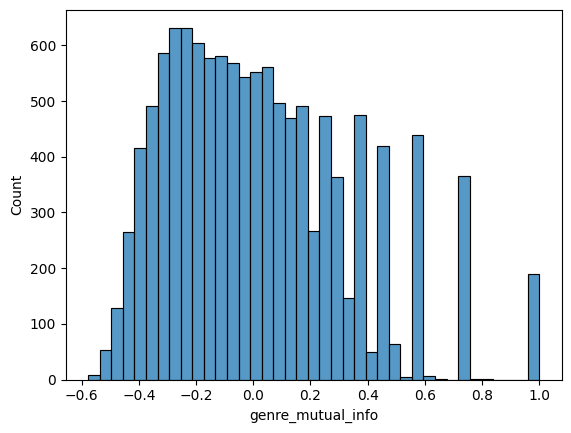

In [21]:
sns.histplot(genres_mutual_information["genre_mutual_info"])

### Inspecting particular actors

In [22]:
# Minimum amount of movies
min_movies = 10

# Inspect actor (0 (first) => least polarized, -1 (last) => most polarized)
actor_index = -1

genres_mu_inspect = genres_mutual_information[genres_mutual_information.total_movies >= min_movies].reset_index(drop=True).copy()

In [23]:
inspected_genres = list(zip(genres_mu_inspect.iloc[actor_index]["genres_freq"], movie_genres[0].to_list()))
print(f"Actor name: {genres_mu_inspect.iloc[actor_index]['actor_name']} | Total movies: {genres_mu_inspect.iloc[actor_index]['total_movies']}", end ="\n\n")
for frac, genre in inspected_genres:
    if frac != 0:
        print(f"{genre}: {frac*100:.2f}%")

Actor name: Noriko Ohara | Total movies: 23

Animation: 11.54%
Anime: 3.85%
Japanese Movies: 84.62%
